In [1]:
import sys
assert sys.version_info >= (3, 6), "Python 3.6 required for this notebook."

In [2]:
# get latest version of packages
! pip install --upgrade pandas sklearn seaborn jupyterthemes tqdm statsmodels

Requirement already up-to-date: pandas in /Users/pmascolo/anaconda/lib/python3.6/site-packages (0.23.1)
Requirement already up-to-date: sklearn in /Users/pmascolo/anaconda/lib/python3.6/site-packages (0.0)
  Using cached https://files.pythonhosted.org/packages/bc/ee/1921d0f873bd56fca378ad938eaff7cc2ab3e622ed6c035d968924c17677/jupyterthemes-0.19.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/93/24/6ab1df969db228aed36a648a8959d1027099ce45fad67532b9673d533318/tqdm-4.23.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/29/df/1f8233500d8bb90f16fd066560f3805197e568af611ca97eddd5fb81b012/statsmodels-0.9.0-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
Requirement not upgraded as not directly required: python-dateutil>=2.5.0 in /Users/pmascolo/anaconda/lib/python3.6/site-packages (from pandas) (2.7.0)
Requirement not upgraded as not directly required: pytz>=2011k in /Users/p

In [3]:
import collections
import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from jupyterthemes import jtplot
from numpy.random import seed
from pandas.plotting import parallel_coordinates

jtplot.style(theme='grade3', ticks=True, grid=False, figsize=(20, 12))

In [4]:
data_file = "../data/time_series_bonds.xlsx"
data = pd.read_excel(data_file, sheet_name="d").set_index("date")
nrows, ncols = data.shape
print(f"Loaded {nrows} rows x {ncols} series")

holed_series = np.array([i if i != 0.0 else np.nan for i in data['n1']])
interpolated = pd.Series(holed_series).interpolate()
interpolated.index = data.index
data['n1'] = interpolated

Loaded 556 rows x 200 series


In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcaed = pca.fit_transform(data.describe().T / data.describe().T.max())
print(pca.explained_variance_ratio_)

[0.9314316  0.06748259]


It's worth remembering that the first PC is mostly driven by standard deviation while all variables contribute to the second.

# Frequency domain

Sometimes when classifying temporal data, the frequency domain can contain important information on the structure of the signals and can therefore highlight differences or similarities that are not apparent in the time domain. 

In [8]:
import copy
import scipy.fftpack as fftpack

In [20]:
_df = copy.deepcopy(data)
df = pd.DataFrame()
N = _df.shape[0]

for col in tqdm.tqdm_notebook(list(_df)):
    yf = fftpack.fft(_df[col])
    yf = 2.0/N * np.abs(yf[:N//2])
    df[col] = yf


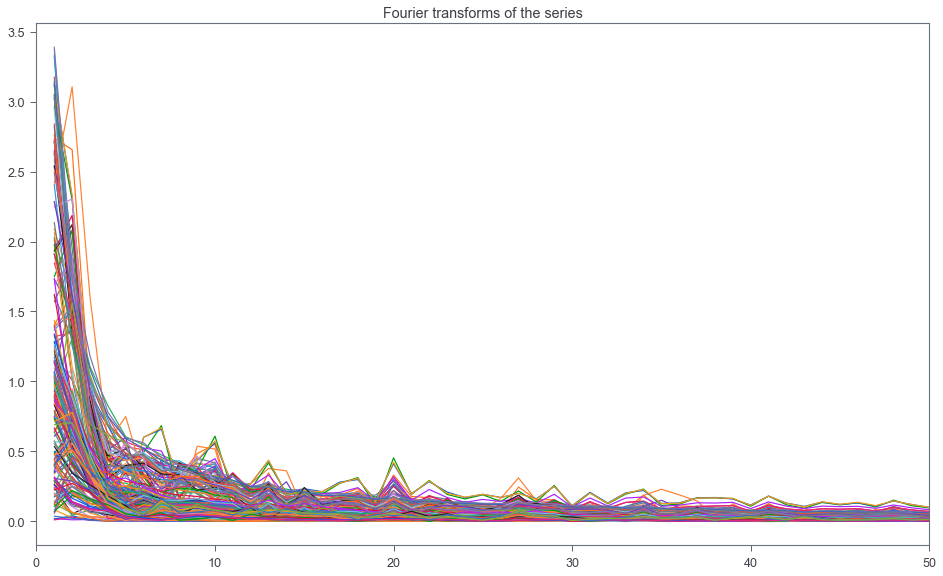

In [39]:
df.iloc[1:].plot(legend=False)
plt.xlim(0, 50)
# plt.yscale("log")
plt.title("Fourier transforms of the series")
plt.show()

In the graph above, the first harmonic (mean of the signal) is omitted for scale. Some similarities are visible in the graph. Some distinct groups are clearly visible in the graph.

A hierarchical clustering can be attempted on the Fourier transforms of the series:

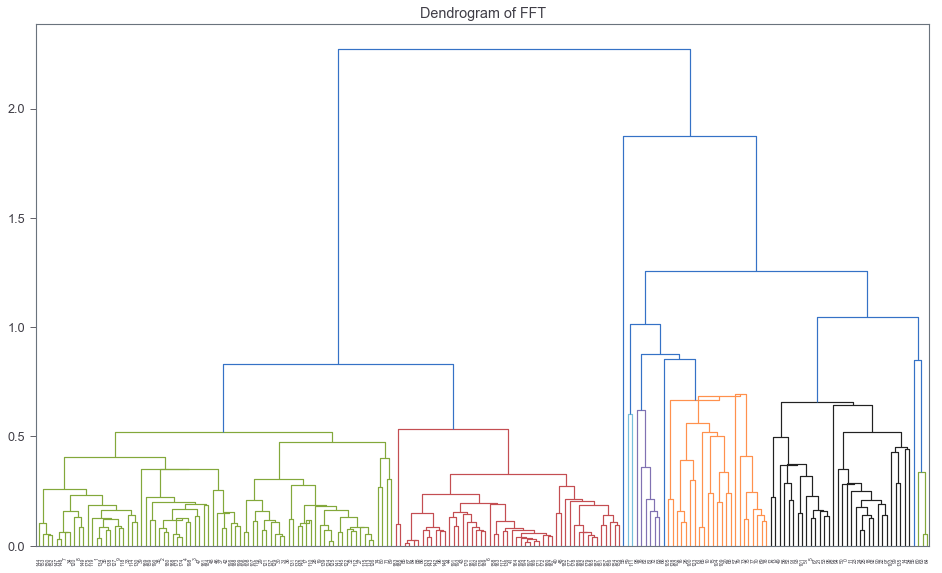

In [74]:
from scipy.cluster import hierarchy

Z = hierarchy.linkage(df.iloc[1: 51].T, 'centroid')
hierarchy.dendrogram(Z, color_threshold=0.75)
plt.title("Dendrogram of FFT")

plt.show()

In [75]:
clusters = hierarchy.fcluster(Z, 0.75, criterion='distance')

In [82]:
d = data.T
d['cluster'] = clusters

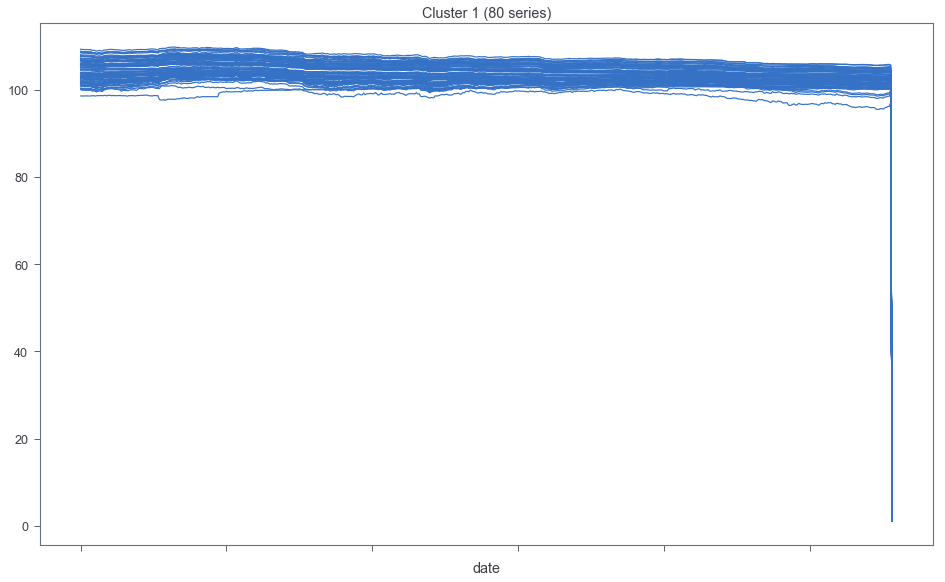

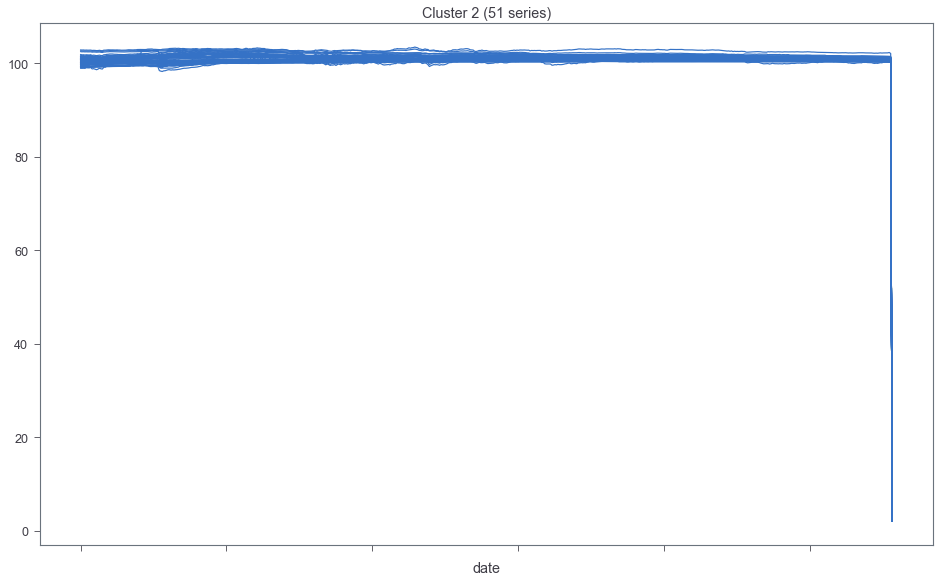

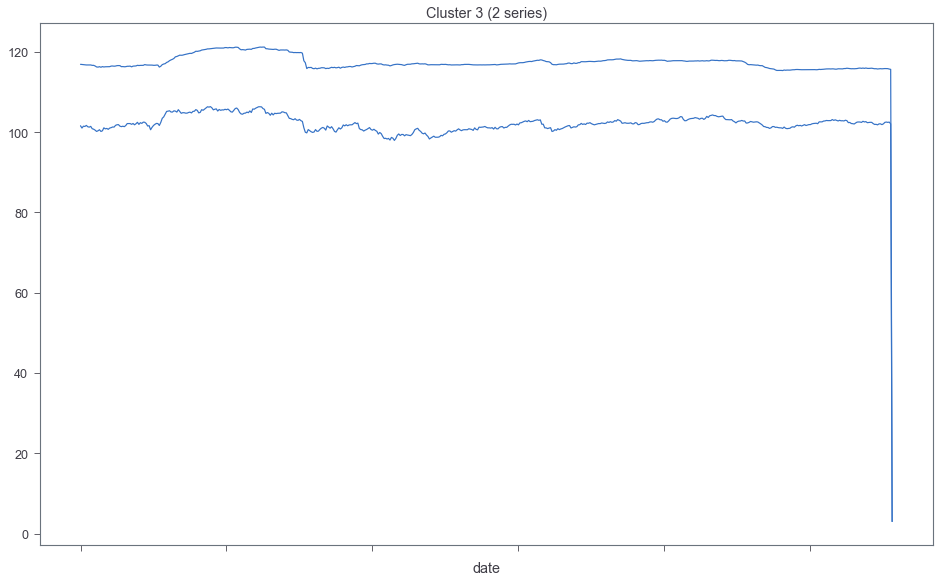

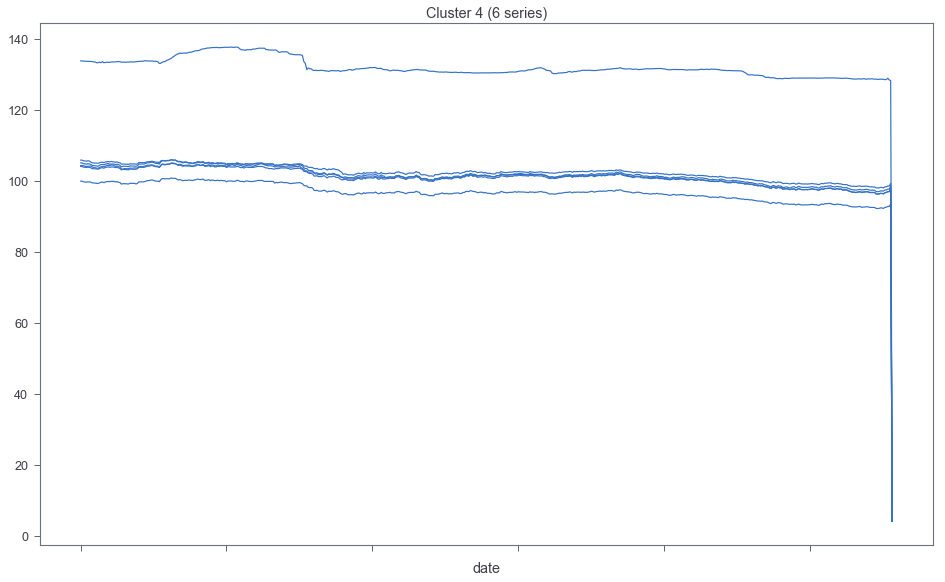

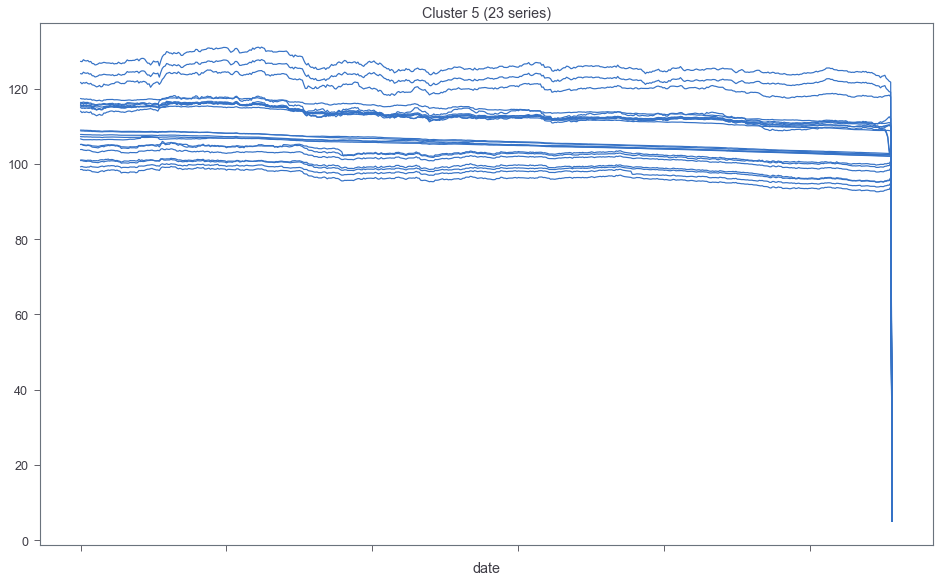

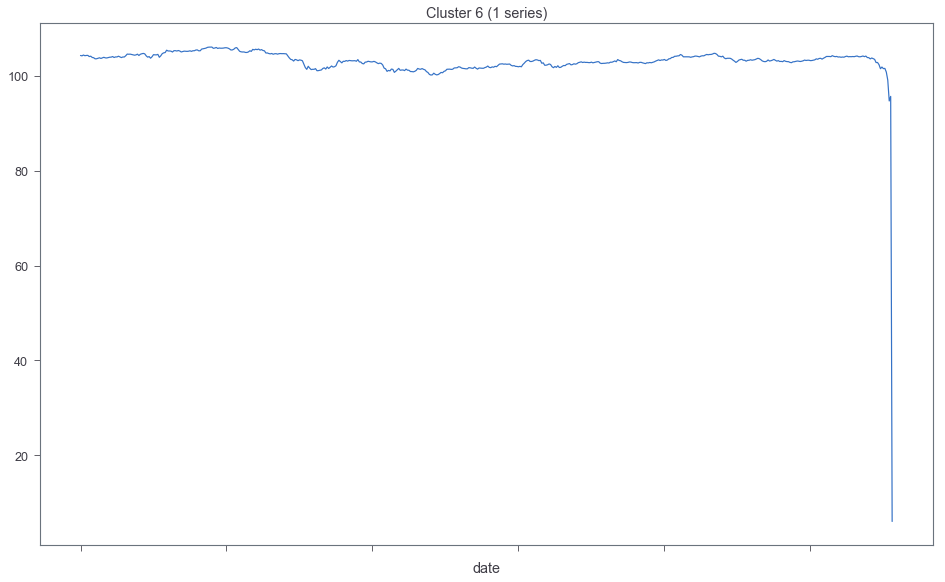

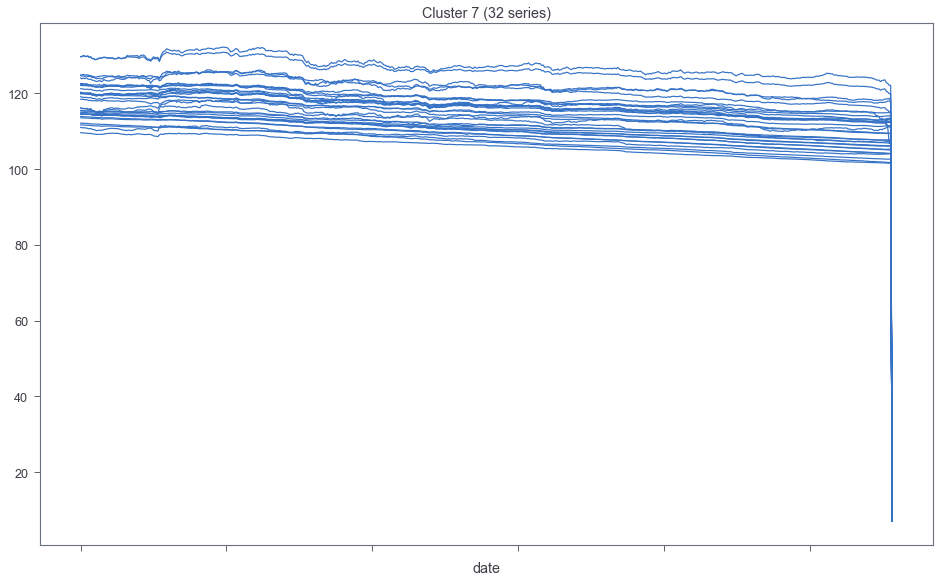

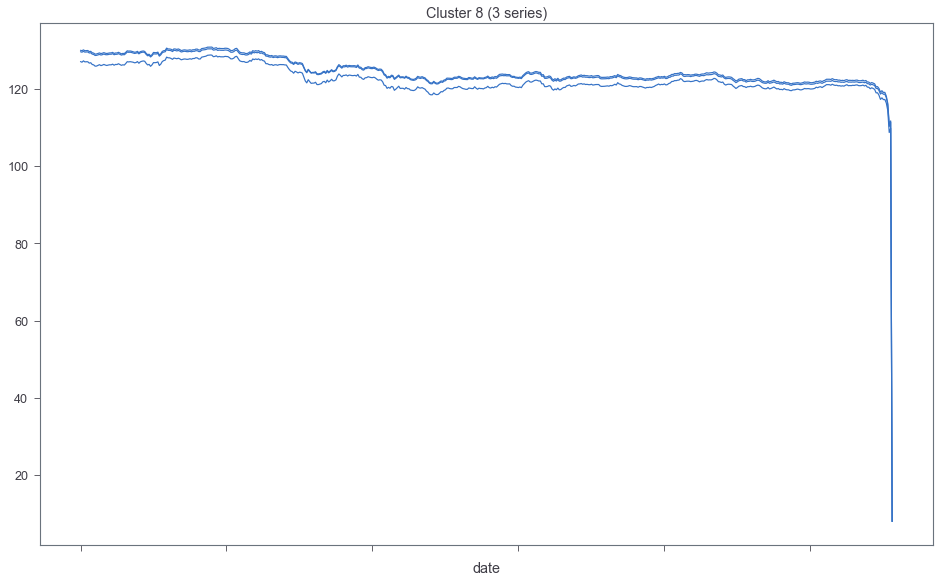

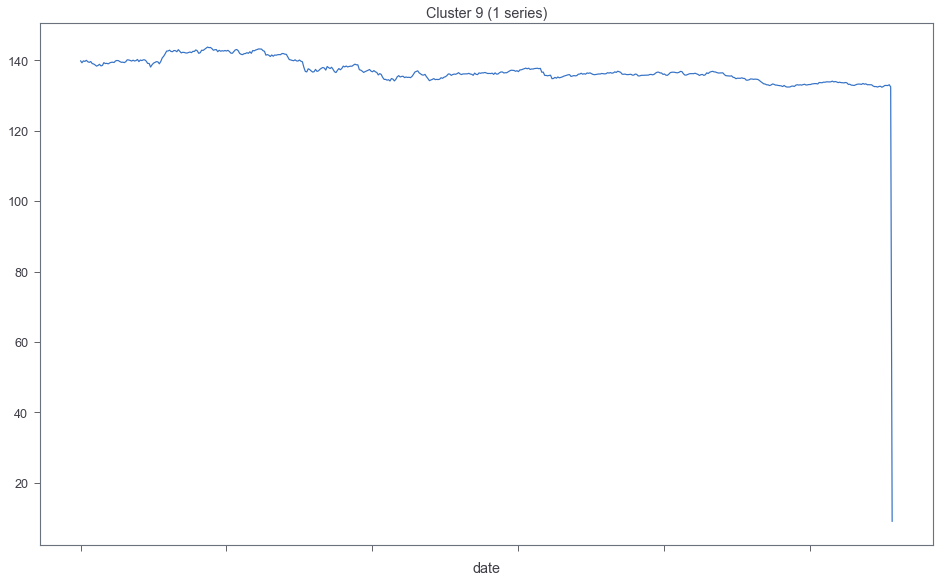

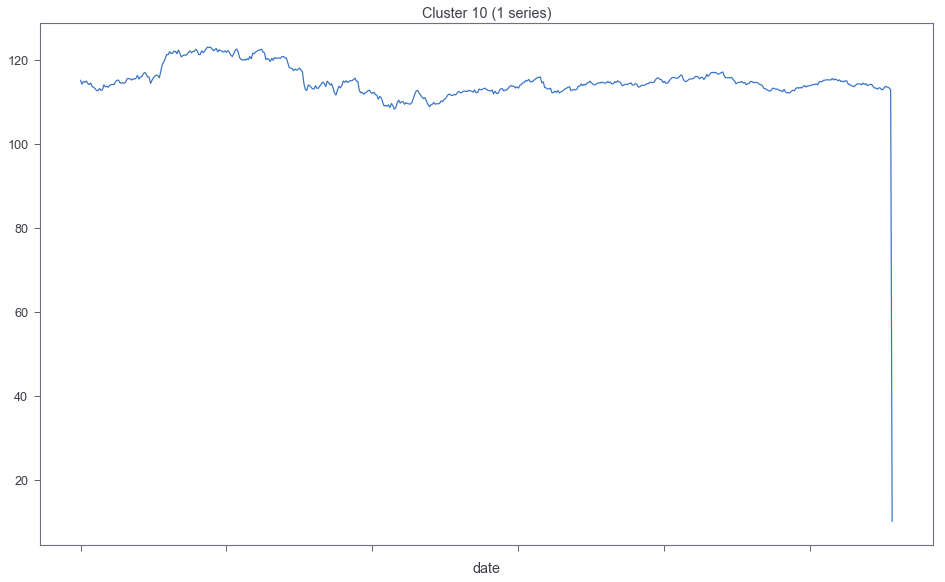

In [85]:
for cluster in sorted(d.cluster.unique()):
    _d = d[d.cluster == cluster]
    _d.T.plot(legend=False, c="b")
    plt.title(f"Cluster {cluster} ({_d.shape[0]} series)")
    plt.show()

In [81]:
import collections
collections.Counter(clusters)

Counter({1: 80, 2: 51, 3: 2, 4: 6, 5: 23, 6: 1, 7: 32, 8: 3, 9: 1, 10: 1})